In [1]:
%matplotlib inline
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import partial
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import cross_validation

# Initialization

Read the training and test data:

In [2]:
df = pd.read_csv('train.csv', header=0)
df_test = pd.read_csv('test.csv', header=0)

In [3]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
print df.info()
print
print df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null

# Data Cleaning and Prep

I am going to approach data cleaning as a set of composable functions.  That way I can set up the functions once and apply them to both the training and test data.  

In [5]:
prep_data_funcs = {}

In [6]:
def prep_data(df, prep_funcs, verbose=False) :
    for name,func in prep_funcs.items() :
        if verbose : print 'Applying function ' + name
        df = func(df)
        
    return df

## Cabin

There is a lot of Cabin data missing.  Will ignore that feature for now.

In [7]:
prep_data_funcs['Drop cabin'] = lambda df : df.drop('Cabin',axis=1)

## Age

The "Age" variable is also missing a lot of entries.  Let's look closer.

Mean age is  29.6991176471
Median age is  28.0


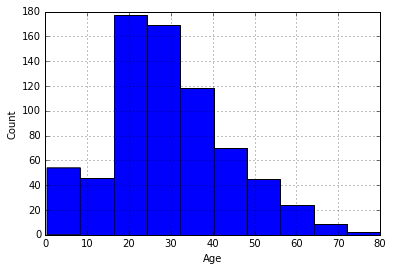

In [8]:
df['Age'].hist()
plt.xlabel('Age')
plt.ylabel('Count')

print 'Mean age is ', df['Age'].mean()
print 'Median age is ', df['Age'].median()

Calculate median age by gender and passenger class

In [23]:
median_ages = np.zeros((2,3))
mean_ages = np.zeros((2,3))
std_ages = np.zeros((2,3))
gender = ('female', 'male')
for i in range(0,2) : # gender
    for j in range(0,3) : # passenger class
        median_ages[i,j] = df[(df['Sex']==gender[i]) & (df['Pclass']==j+1)]['Age'].dropna().median()
        mean_ages[i,j] = df[(df['Sex']==gender[i]) & (df['Pclass']==j+1)]['Age'].dropna().mean()
        std_ages[i,j] = df[(df['Sex']==gender[i]) & (df['Pclass']==j+1)]['Age'].dropna().std()
        
print "Median Ages:"
print pd.DataFrame(median_ages,index=gender,columns=(1,2,3))
print
print "Mean Ages:"
print pd.DataFrame(mean_ages,index=gender,columns=(1,2,3))
print
print "Standard Deviation of Ages:"
print pd.DataFrame(std_ages,index=gender,columns=(1,2,3))

Median Ages:
           1     2     3
female  35.0  28.0  21.5
male    40.0  30.0  25.0

Mean Ages:
                1          2          3
female  34.611765  28.722973  21.750000
male    41.281386  30.740707  26.507589

Standard Deviation of Ages:
                1          2          3
female  13.612052  12.872702  12.729964
male    15.139570  14.793894  12.159514


Populate missing age values with the medians calculated above

In [24]:
def map_sex_and_fill_age(df,age_map) : 
    df['Gender'] = df['Sex'].map({'female':0, 'male':1}).astype(int)
    df = df.drop('Sex', axis=1)

    df['AgeFill'] = df['Age']
    for i in range(0, 2):
        for j in range(0, 3):
            df.loc[ (df.Age.isnull()) & (df.Gender == i) & (df.Pclass == j+1),'AgeFill'] = age_map[i,j]
            
    return df.drop('Age', axis=1)

prep_data_funcs['Map sex and fill age'] = partial(map_sex_and_fill_age,age_map=median_ages)

Drop features that seem irrelevant

In [25]:
prep_data_funcs['Drop irrelevant features'] = lambda df: df.drop(['PassengerId', 'Ticket', 'Fare'], axis=1)

## Embarked

What about where they embarked from? There are two missing values in the training set, none in the testing set.

In [26]:
print df['Embarked'].value_counts()
df['Embarked'] = df['Embarked'].fillna('S')
print df['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64
S    646
C    168
Q     77
Name: Embarked, dtype: int64


In [27]:
def map_embarked(df) :
    df['Embarked_S'] = 0
    df.loc[df['Embarked']=='S','Embarked_S'] = 1
    df['Embarked_C'] = 0
    df.loc[df['Embarked']=='C','Embarked_C'] = 1
    df['Embarked_Q'] = 0
    df.loc[df['Embarked']=='Q','Embarked_Q'] = 1
    return df.drop('Embarked',axis=1)

prep_data_funcs['Map Embarked'] = map_embarked

## Name and Title

Apparently a passenger's title is a good indicator of survival

In [28]:
df['Name'].str.extract("(.*, )([^\.]+)", expand=False)[1].value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Col               2
Major             2
Lady              1
Jonkheer          1
Don               1
Ms                1
Mme               1
Capt              1
the Countess      1
Sir               1
Name: 1, dtype: int64

In [29]:
def create_titles(df) :
    title = df['Name'].str.extract("(.*, )([^\.]+)", expand=False)[1]
    
    df['Mr'] = 0
    df['Mrs'] = 0
    df['Miss'] = 0
    df['Master'] = 0
    df.loc[title.isin(['Mr','Sir','Dr','Rev','Major','Col','Don','Jonkheer','Capt']),'Mr'] = 1
    df.loc[title.isin(['Mrs','Ms','Lady','Mme','the Countess','Dona']),'Mrs'] = 1
    df.loc[title.isin(['Miss','Mlle']),'Miss'] = 1
    df.loc[title.isin(['Master']),'Master'] = 1
    return df.drop('Name',axis=1)

prep_data_funcs['Make titles'] = create_titles

Clean up all of the data

In [30]:
train_data = prep_data(df,prep_data_funcs)
test_data = prep_data(df_test,prep_data_funcs)
y = train_data.pop('Survived')

print test_data.info()
print
print train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 12 columns):
Pclass        418 non-null int64
SibSp         418 non-null int64
Parch         418 non-null int64
Mr            418 non-null int64
Mrs           418 non-null int64
Miss          418 non-null int64
Master        418 non-null int64
Gender        418 non-null int64
AgeFill       418 non-null float64
Embarked_S    418 non-null int64
Embarked_C    418 non-null int64
Embarked_Q    418 non-null int64
dtypes: float64(1), int64(11)
memory usage: 39.3 KB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
Pclass        891 non-null int64
SibSp         891 non-null int64
Parch         891 non-null int64
Mr            891 non-null int64
Mrs           891 non-null int64
Miss          891 non-null int64
Master        891 non-null int64
Gender        891 non-null int64
AgeFill       891 non-null float64
Embarked_S    891 non-null int64
Em

# Feature Investigation

## 0. Overall survival rate

In [42]:
print len(df[y==1])/float(len(df))

0.383838383838


## 1. Age

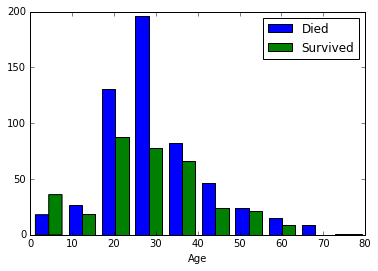

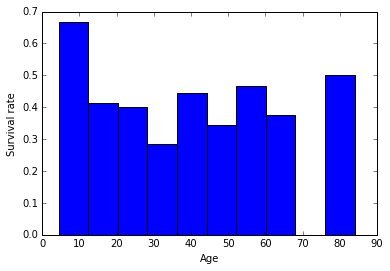

In [43]:
#plt.plot(train_data['AgeFill'],train_data['Gender'],'ro')
plt.figure()
nd,bins,_ = plt.hist((train_data[y==0]['AgeFill'],
                      train_data[y==1]['AgeFill']),
                    histtype='bar',stacked=False,label=['Died','Survived'])
plt.xlabel('Age')
plt.legend()

plt.figure()
plt.bar((bins[0:-1]+bins[1:])/2.0,nd[1]/(nd[1]+nd[0]),width=bins[1:]-bins[0:-1])
plt.xlabel('Age')
plt.ylabel('Survival rate')

Looks like children had higher than average survival rate

In [44]:
def create_child_feature(df) :
    df['Child'] = 0
    df.loc[df['AgeFill']<15,'Child'] = 1
    return df

## SibSp

Survival # wrt to number of Sib/Sp
0    210
1    112
2     13
3      4
4      3
Name: SibSp, dtype: int64


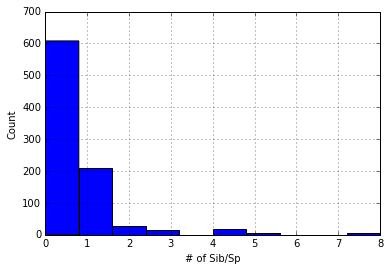

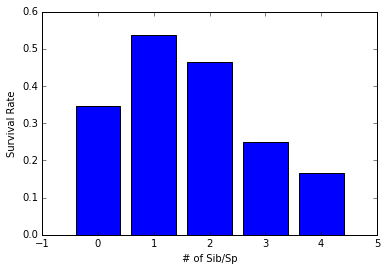

In [45]:
df['SibSp'].hist()
plt.xlabel('# of Sib/Sp')
plt.ylabel('Count')

n_surv = df.loc[y==1,'SibSp'].value_counts()
n_tot = df['SibSp'].value_counts()
print 'Survival # wrt to number of Sib/Sp'
print n_surv

a = [(i,n_surv[i]/float(n_tot[i])) for i in range(10) if i in n_surv]
n,f = zip(*a)
plt.figure()
plt.bar(n,f,align='center')
plt.xlabel('# of Sib/Sp')
plt.ylabel('Survival Rate')

From this it looks like there is a (near) linear relationship between `SibSp` and Survival unless there is no Sibling/Spouse.

In [46]:
def create_sibsp_feature(df) :
    df['SibSp12'] = 0
    df.loc[df['SibSp']==1,'SibSp12'] = 1
    df.loc[df['SibSp']==1,'SibSp12'] = 1
    df['SibSp0'] = 0
    df.loc[df['SibSp']==0,'SibSp0'] = 1
    df['SibSpGt2'] = 0
    df.loc[df['SibSp']>2,'SibSpGt2'] = 1
    return df.drop('SibSp',axis=1)

## Parch

Survival # wrt to number of Par/Ch
0    233
1     65
2     40
3      3
5      1
Name: Parch, dtype: int64


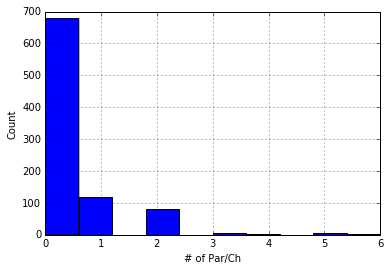

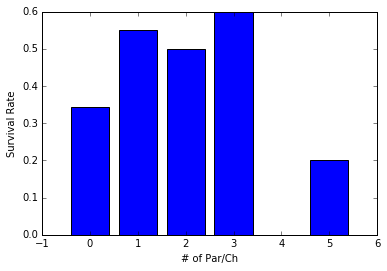

In [47]:
df['Parch'].hist()
plt.xlabel('# of Par/Ch')
plt.ylabel('Count')

n_surv = df.loc[y==1,'Parch'].value_counts()
n_tot = df['Parch'].value_counts()
print 'Survival # wrt to number of Par/Ch'
print n_surv

a = [(i,n_surv[i]/float(n_tot[i])) for i in range(10) if i in n_surv]
n,f = zip(*a)
plt.figure()
plt.bar(n,f,align='center')
plt.xlabel('# of Par/Ch')
plt.ylabel('Survival Rate')

In [48]:
def create_parch_feature(df) :
    df['Parch123'] = 0
    df.loc[df['Parch']==1,'Parch123'] = 1
    df.loc[df['Parch']==2,'Parch123'] = 1
    df.loc[df['Parch']==3,'Parch123'] = 1
    return df.drop('Parch',axis=1)

In [49]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
Pclass        891 non-null int64
SibSp         891 non-null int64
Parch         891 non-null int64
Mr            891 non-null int64
Mrs           891 non-null int64
Miss          891 non-null int64
Master        891 non-null int64
Gender        891 non-null int64
AgeFill       891 non-null float64
Embarked_S    891 non-null int64
Embarked_C    891 non-null int64
Embarked_Q    891 non-null int64
dtypes: float64(1), int64(11)
memory usage: 83.6 KB


In [50]:
def feature_selection(data) :
    data_ext = data.copy()
    data_ext = create_child_feature(data_ext)
    data_ext = create_sibsp_feature(data_ext)
    data_ext = create_parch_feature(data_ext)
    #data_ext['SibSp^2'] = data_ext['SibSp']**2
    #data_ext['SibSp^3'] = data_ext['SibSp']**3
    data_ext.drop('AgeFill',axis=1,inplace=True)
    
    #data_ext['Age^2'] = data['AgeFill']**2
    

    return (data_ext - data_ext.mean())/data_ext.std()

In [63]:
train_data_ext = feature_selection(train_data)
test_data_ext = feature_selection(test_data)

lr = LogisticRegression(tol=1.0e-4)
lr.fit(train_data_ext.values,y)
output = lr.predict(train_data_ext.values)

print 'niter = ', lr.n_iter_
print 'Prediction accuracy = ', sum(y==output)/float(len(output))
print '5-Fold cross validation = ', np.mean(cross_validation.cross_val_score(lr, train_data_ext, y, cv=5))

output = lr.predict(test_data_ext.values)

for col,coeff in zip(train_data_ext.columns,lr.coef_[0]) :
    print col, coeff

with open('output_lr.csv','wb') as csv_file :
    output_file = csv.writer(csv_file)
    output_file.writerow(["PassengerId", "Survived"])
    for pid,s in zip(df_test['PassengerId'],output) :       # For each row in test.csv
        output_file.writerow([pid,int(s)])

niter =  5
Prediction accuracy =  0.821548821549
5-Fold cross validation =  0.814855909329
Pclass -0.852735927852
Mr -0.503225412403
Mrs 0.202043865767
Miss 0.145300467554
Master 0.561242383283
Gender -0.790267683233
Embarked_S -0.0979982304635
Embarked_C 0.0920116810092
Embarked_Q 0.0276373648571
Child 0.0919227128971
SibSp12 -0.0623474589134
SibSp0 0.0301384731933
SibSpGt2 -0.568255950416
Parch123 -0.0598260436481


In [64]:
train_data_ext = feature_selection(train_data)
test_data_ext = feature_selection(test_data)

forest = RandomForestClassifier(n_estimators = 100)
forest = forest.fit(train_data_ext.values,y)
output = forest.predict(train_data_ext.values)

print 'Prediction accuracy = ', sum(y==output)/float(len(output))
print '5-Fold cross validation = ', np.mean(cross_validation.cross_val_score(forest, train_data_ext, y, cv=5))

output = forest.predict(test_data_ext.values)

with open('output_rf.csv','wb') as csv_file :
    output_file = csv.writer(csv_file)
    output_file.writerow(["PassengerId", "Survived"])
    for pid,s in zip(df_test['PassengerId'],output) :       # For each row in test.csv
        output_file.writerow([pid,int(s)])

Prediction accuracy =  0.854096520763
5-Fold cross validation =  0.82159755329


Should categorical variables "work" with logistic regression?
Maybe make as seperate features...